<div align="center"><h1>
FYS-STK4155 - Project 1 Notebook
</div>
<div align="center"><h2>
Håvard Skåli, Erik Røset and Oskar Idland
</div>
<hr style="border:2px solid gray"> </hr>
<div align="center"><h3>
Part 2: Analysis of Cosmological Simulation Data
</div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from functions import *
plt.rcParams.update({'text.usetex': True, 'font.size': 16, 'font.family': 'serif', 'font.serif': 'Computer Modern Sans Serif', 'font.weight': 100, 'mathtext.fontset': 'cm', 'xtick.labelsize': 14, 'ytick.labelsize': 14})

seed = 43
np.random.seed(seed)

### Importing the data

#### Dark matter simulation data at redshift $z\approx12.88$

In [52]:
with open("../data/darkmatter_1288.txt", "r") as infile:
    params = infile.readline().split(",")
    # The box unit, density unit, dimensionless Hubble constant, x and y are the same for both redshifts
    box_unit, rho_unit, h, a_1288 = params[0].split(": ")[1], params[1].split(": ")[1], float(params[2].split(": ")[1]), float(params[3].split(": ")[1]) 
    y = np.array(infile.readline().split(), dtype = float)
    x = []; rho_1288 = []
    for line in infile:
        vals = line.split()
        x.append(float(vals[-1]))
        rho_1288.append(np.array(vals[:-1], dtype = float))
x = np.array(x); rho_1288 = np.array(rho_1288)

#### Dark matter simulation data at redshift $z=0$

In [53]:
# The box unit, density unit, dimensionless Hubble constant, x and y are the same for both redshifts, so we only store the values of a and ρ this time

with open("../data/darkmatter_0.txt", "r") as infile:
    params = infile.readline().split(",")
    a_0 = float(params[3].split(": ")[1]) 
    infile.readline()
    rho_0 = []
    for line in infile:
        vals = line.split()
        rho_0.append(np.array(vals[:-1], dtype = float))
rho_0 = np.array(rho_0)

### Visualizing the data

#### Using imshow

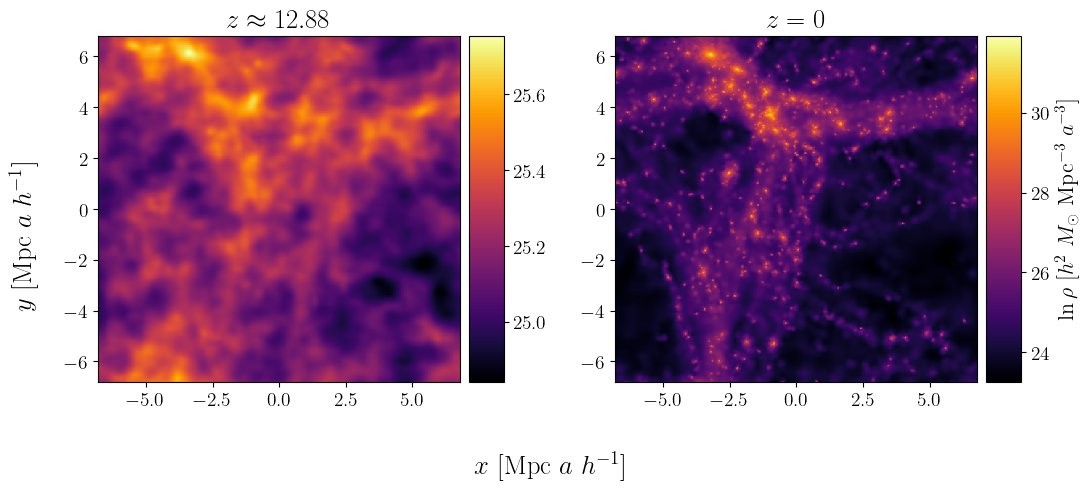

In [54]:
xx, yy = np.meshgrid(x, y)

fig, axs = plt.subplots(1, 2, figsize = (11.25, 5))
im_1288 = axs[0].imshow(np.log(rho_1288[::-1]), cmap = "inferno", aspect = "auto", interpolation = "nearest", extent = [np.min(x), np.max(x), np.min(y), np.max(y)])
im_0 = axs[1].imshow(np.log(rho_0[::-1]), cmap = "inferno", aspect = "auto", interpolation = "nearest", extent = [np.min(x), np.max(x), np.min(y), np.max(y)])

plt.colorbar(im_1288, ax = axs[0], pad = 0.02, aspect = 10)
plt.colorbar(im_0, ax = axs[1], label = r"$\ln\rho$ [" + rho_unit + "]", pad = 0.02, aspect = 10)

axs[0].set_title(r"$z\approx12.88$")
axs[1].set_title(r"$z=0$")

fig.supxlabel(r"$x$ [" + box_unit + "]")
fig.supylabel(r"$y$ [" + box_unit + "]")

plt.tight_layout()
plt.savefig("../figs/density.pdf")
plt.show()

#### Using surface plots

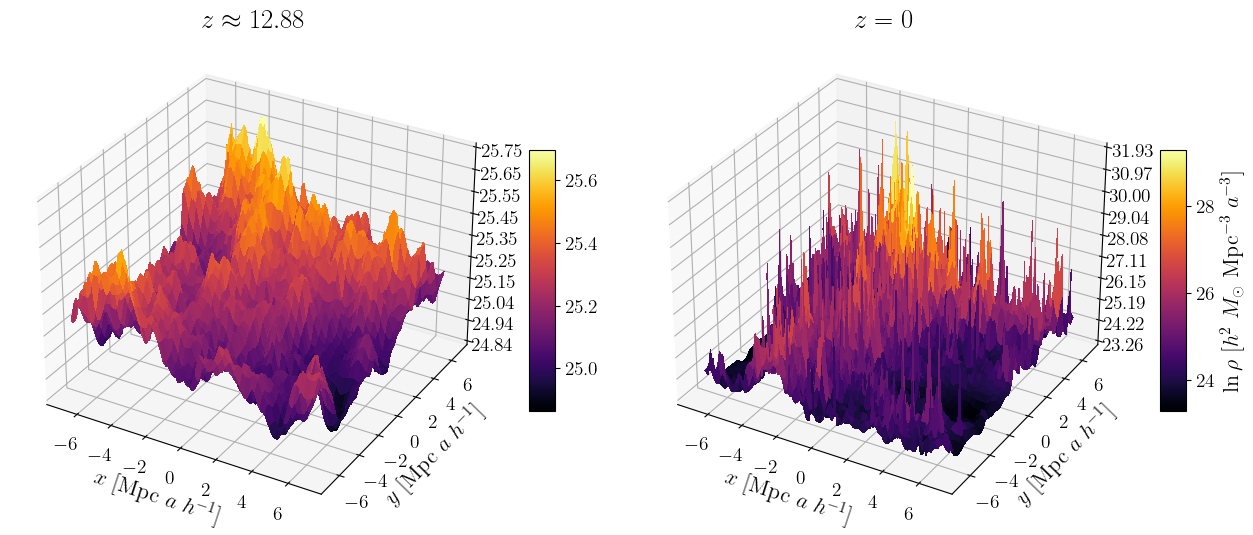

In [55]:
fig = plt.figure(figsize = (13, 7))
axs = [fig.add_subplot(121, projection = "3d"), fig.add_subplot(122, projection = "3d")]

surf_1288 = axs[0].plot_surface(xx, yy, np.log(rho_1288), cmap = "inferno", linewidth = 0, antialiased = False)
surf_0 = axs[1].plot_surface(xx, yy, np.log(rho_0), cmap = "inferno", linewidth = 0, antialiased = False)

fig.colorbar(surf_1288, shrink = 0.4, aspect = 10)
fig.colorbar(surf_0, shrink = 0.4, aspect = 10, label = r"$\ln\rho$ [" + rho_unit + "]")

titles = [r"$z\approx12.88$", r"$z=0$"]
for i in range(2):
    axs[i].zaxis.set_major_locator(LinearLocator(10))
    axs[i].zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    axs[i].set_xlabel(r"$x$ [" + box_unit + "]")
    axs[i].set_ylabel(r"$y$ [" + box_unit + "]")
    axs[i].set_title(titles[i])
    
plt.tight_layout()
plt.savefig("../figs/density_surf.pdf")
plt.show()

### OLS: MSE and $R^2$ as function of polynomial degree for scaled and raw data

#### Polynomial degrees up to 40

In [70]:
x.reshape(-1, 1); y.reshape(-1, 1) 
z_1288 = np.log(rho_1288).reshape(-1, 1) 
z_0 = np.log(rho_0).reshape(-1, 1) 

MSE_raw_list = []
MSE_scaled_list = []
R2_raw_list = []
R2_scaled_list = []
β_raw_list = []
β_scaled_list = []

degrees = range(1, 41, 2)
z_list = [z_1288, z_0]
for z in z_list:
    MSE_raw_list.append([])
    MSE_scaled_list.append([])
    R2_raw_list.append([])
    R2_scaled_list.append([])
    β_raw_list.append([])
    β_scaled_list.append([])
    for degree in degrees:
        # Raw
        MSE_raw, R2_raw, β_raw = OLS(x, y, z, degree, scale = False, seed = seed, intercept = True, return_beta = True)
        
        MSE_raw_list[-1].append(MSE_raw)
        R2_raw_list[-1].append(R2_raw)
        β_raw_list[-1].append(β_raw)
        
        # Scaled
        MSE_scaled, R2_scaled, β_scaled = OLS(x, y, z, degree, seed = seed, return_beta = True)
        
        MSE_scaled_list[-1].append(MSE_scaled)
        R2_scaled_list[-1].append(R2_scaled)
        β_scaled_list[-1].append(β_scaled)

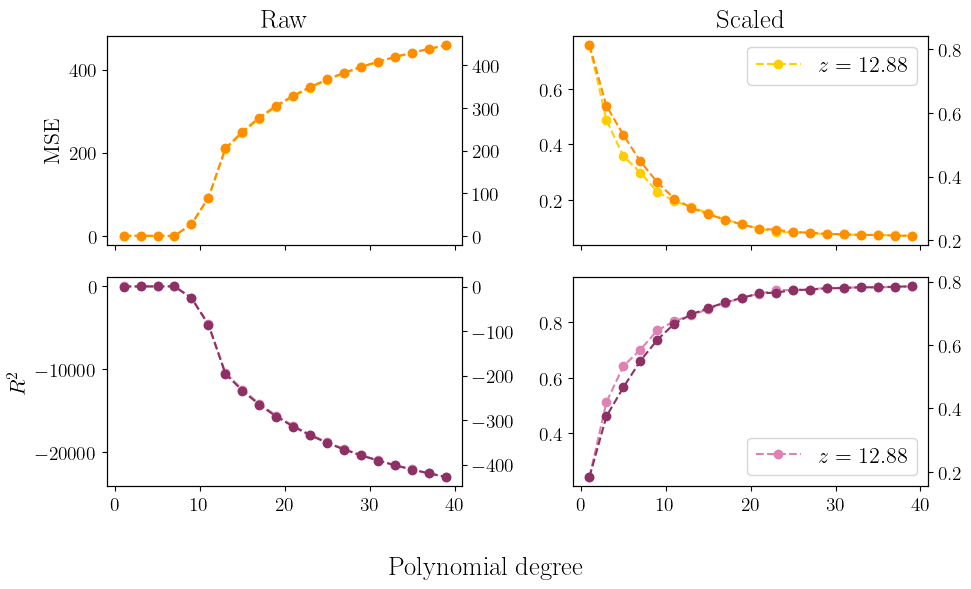

In [71]:
colors = [["#ffce00", "#ff8d00"], ["#de82b4", "#8d3063"]]
titles = ["Raw", "Scaled"]
ylabels = ["MSE", r"$R^2$"]
values = np.array([[MSE_raw_list, MSE_scaled_list], [R2_raw_list, R2_scaled_list]])

# Plotting in grid
fig, axs = plt.subplots(2, 2, sharex = True, figsize = (10, 6))
for i in range(2):
    axs[i, 0].set_ylabel(ylabels[i])
    for j in range(2):
        axs[i, j].plot(degrees, values[i, j][0], "--o", color = colors[i][0], label = r"$z=12.88$")
        ax_2 = axs[i, j].twinx()
        ax_2.plot(degrees, values[i, j][1], "--o", color = colors[i][1], label = r"$z=0$")
        if i == 0:
            axs[i, j].set_title(titles[j])
    axs[i, 1].legend()
fig.supxlabel('Polynomial degree')
plt.tight_layout()
plt.savefig("../figs/g_error_scaled_vs_raw_40.pdf")
plt.show()

In [ ]:
#TODO why extreme values for raw?

#### Polynomial degrees up to 7

In [72]:
x.reshape(-1, 1); y.reshape(-1, 1) 
z_1288 = np.log(rho_1288).reshape(-1, 1) 
z_0 = np.log(rho_0).reshape(-1, 1) 

MSE_raw_list = []
MSE_scaled_list = []
R2_raw_list = []
R2_scaled_list = []
β_raw_list = []
β_scaled_list = []

degrees = range(1, 8)
z_list = [z_1288, z_0]
for z in z_list:
    MSE_raw_list.append([])
    MSE_scaled_list.append([])
    R2_raw_list.append([])
    R2_scaled_list.append([])
    β_raw_list.append([])
    β_scaled_list.append([])
    for degree in degrees:
        # Raw
        MSE_raw, R2_raw, β_raw = OLS(x, y, z, degree, scale = False, seed = seed, intercept = True, return_beta = True)
        
        MSE_raw_list[-1].append(MSE_raw)
        R2_raw_list[-1].append(R2_raw)
        β_raw_list[-1].append(β_raw)
        
        # Scaled
        MSE_scaled, R2_scaled, β_scaled = OLS(x, y, z, degree, seed = seed, return_beta = True)
        
        MSE_scaled_list[-1].append(MSE_scaled)
        R2_scaled_list[-1].append(R2_scaled)
        β_scaled_list[-1].append(β_scaled)

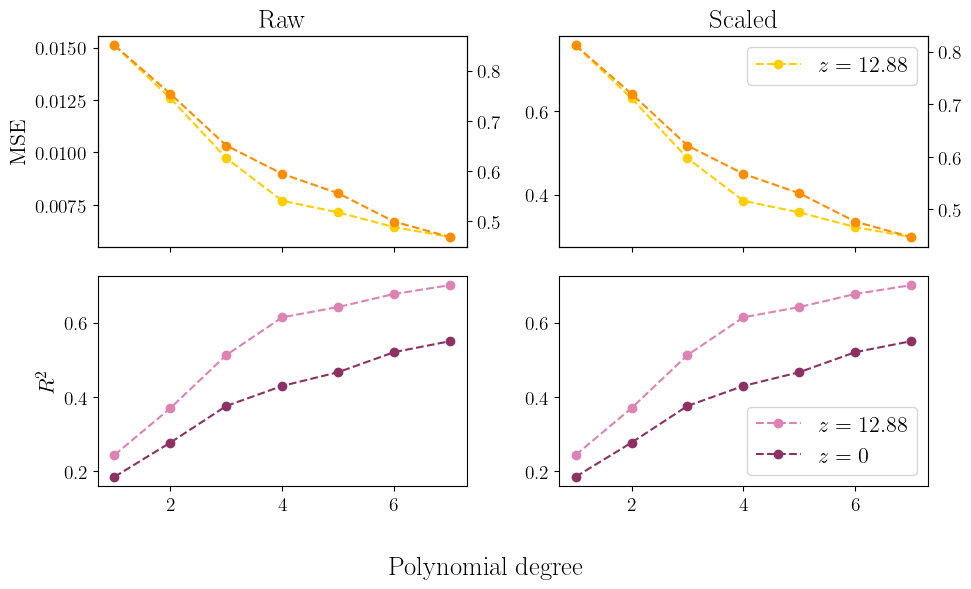

In [73]:
colors = [["#ffce00", "#ff8d00"], ["#de82b4", "#8d3063"]]
titles = ["Raw", "Scaled"]
ylabels = ["MSE", r"$R^2$"]
values = np.array([[MSE_raw_list, MSE_scaled_list], [R2_raw_list, R2_scaled_list]])

# Plotting in grid
fig, axs = plt.subplots(2, 2, sharex = True, figsize = (10, 6))
for i in range(2):
    axs[i, 0].set_ylabel(ylabels[i])
    for j in range(2):
        axs[i, j].plot(degrees, values[i, j][0], "--o", color = colors[i][0], label = r"$z=12.88$")
        if i == 0:
            ax_2 = axs[i, j].twinx()
            ax_2.plot(degrees, values[i, j][1], "--o", color = colors[i][1], label = r"$z=0$")
        else:
            axs[i, j].plot(degrees, values[i, j][1], "--o", color = colors[i][1], label = r"$z=0$")
        if i == 0:
            axs[i, j].set_title(titles[j])
    axs[i, 1].legend()
fig.supxlabel('Polynomial degree')
plt.tight_layout()
plt.savefig("../figs/g_error_scaled_vs_raw.pdf")
plt.show()

#### Comment for the report:

1. Scaling seems to work as it should here as well. Because the $z=12.88$ and $z=0$ datasets are vastly different their raw MSE values will differ in magnitude as well, so it is not as easy to see that the MSE has been scaled by a constant factor in both cases, unless we have two $y$-axes for each of the upper plots. Then the left $y$-axes correspond to $z=12.88$ while the right correspond to $z=0$.
2. The MSE and $R^2$ scores are generally higher and lower, respectively, for the $z=0$ dataset. This makes sense since this dataset has a much more complex structure, hence we need much higher polynomial degrees to get a good fit.
3. Why weird values for raw?

### OLS: Exploring how the fits depend on complexity 

In [101]:
z_list = [z_1288, z_0]
degrees = [5, 10, 20, 30, 50]
z_fits = []
for z in z_list:
    z_fits.append([])
    for degree in degrees:
        MSE_score, R2_score, β, X, scaler_X, scaler_z = OLS(x, y, z, degree, seed = seed, return_beta = True, return_X = True, return_scalers = True)
        z_fits[-1].append(scaler_z.inverse_transform(scaler_X.transform(X) @ β).reshape((len(x), len(y))))

#### Plotting for $z=12.88$ with imshow

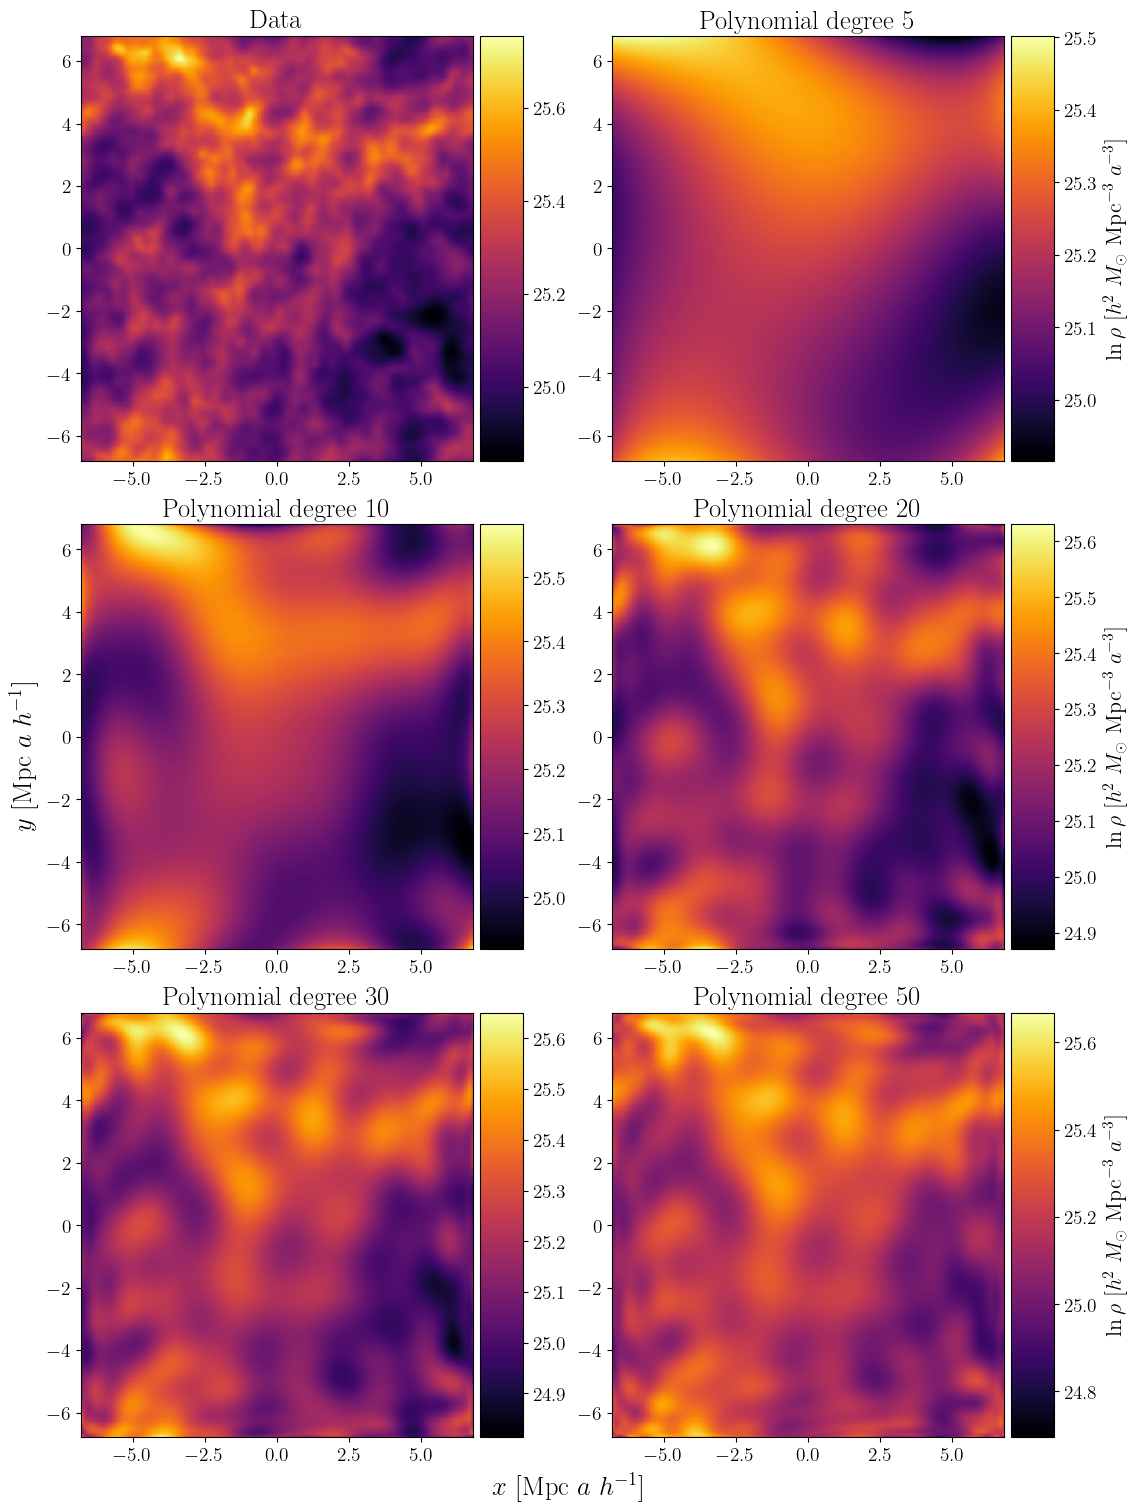

In [108]:
fig, axs = plt.subplots(3, 2, figsize = (11.25, 15), constrained_layout = True)

im = []
idx = 0
for i in range(3):
    for j in range(2):
        if i == 0 and j == 0:
            im.append(axs[i, j].imshow(np.log(rho_1288[::-1]), cmap = "inferno", interpolation = "nearest", aspect = "auto", extent = [np.min(x), np.max(x), np.min(y), np.max(y)]))
            axs[i, j].set_title("Data")
        else:
            im.append(axs[i, j].imshow(z_fits[0][idx][::-1], cmap = "inferno", interpolation = "nearest", aspect = "auto", extent = [np.min(x), np.max(x), np.min(y), np.max(y)]))
            axs[i, j].set_title(f"Polynomial degree {degrees[idx]}")
            idx += 1
        plt.colorbar(im[-1], ax = axs[i, j], label = r"$\ln\rho$ [" + rho_unit + "]" if j == 1 else None, pad = 0.02, aspect = 10)

fig.supxlabel(r"$x$ [" + box_unit + "]")
fig.supylabel(r"$y$ [" + box_unit + "]")
plt.savefig("../figs/density_1288_complexity.pdf")
plt.show()

#### Plotting for $z=0$ with imshow

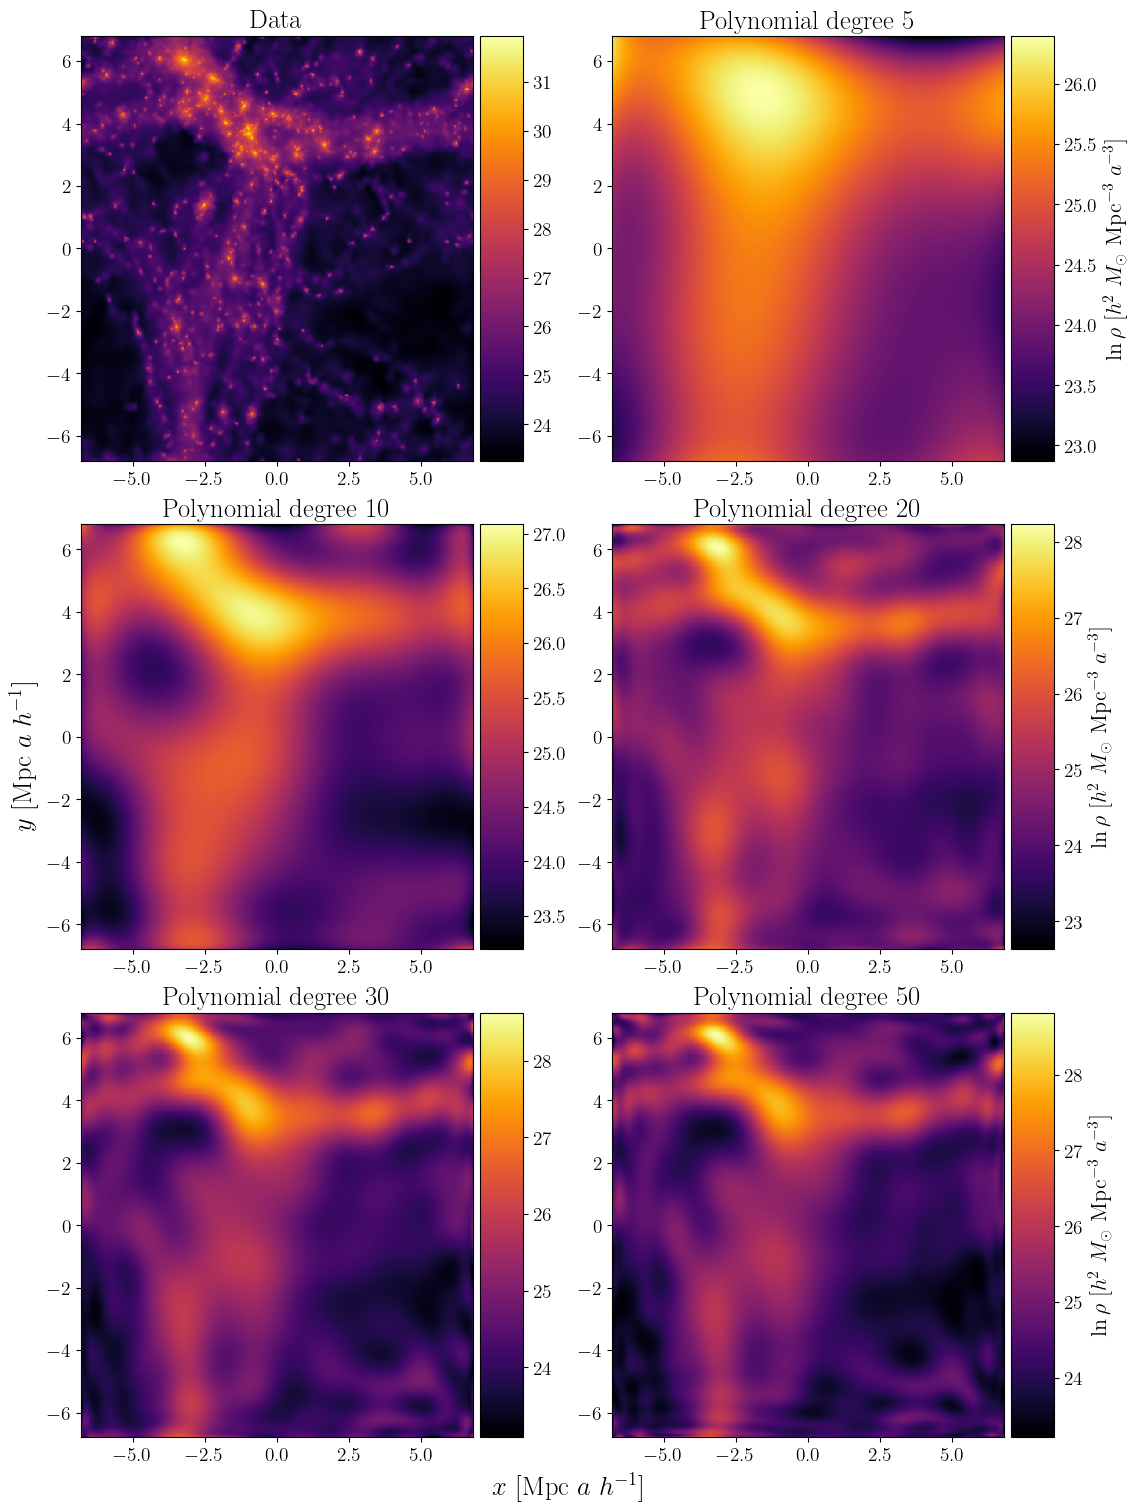

In [109]:
fig, axs = plt.subplots(3, 2, figsize = (11.25, 15), constrained_layout = True)

im = []
idx = 0
for i in range(3):
    for j in range(2):
        if i == 0 and j == 0:
            im.append(axs[i, j].imshow(np.log(rho_0[::-1]), cmap = "inferno", interpolation = "nearest", aspect = "auto", extent = [np.min(x), np.max(x), np.min(y), np.max(y)]))
            axs[i, j].set_title("Data")
        else:
            im.append(axs[i, j].imshow(z_fits[1][idx][::-1], cmap = "inferno", interpolation = "nearest", aspect = "auto", extent = [np.min(x), np.max(x), np.min(y), np.max(y)]))
            axs[i, j].set_title(f"Polynomial degree {degrees[idx]}")
            idx += 1
        plt.colorbar(im[-1], ax = axs[i, j], label = r"$\ln\rho$ [" + rho_unit + "]" if j == 1 else None, pad = 0.02, aspect = 10)

fig.supxlabel(r"$x$ [" + box_unit + "]")
fig.supylabel(r"$y$ [" + box_unit + "]")
plt.savefig("../figs/density_0_complexity.pdf")
plt.show()

#### Comment for the report:

1. EXPLAIN POLYNOMIAL THING WITH ENVELOPE AND RIPPLES
2. FOR HIGH REDSHIFT IT EVENTUALLY TURNS AROUND AND BECOMES MORE SMUDGED

### Dividing datasets into 100 pieces and fitting with degree 30 for each one

In [112]:
x_list = []
y_list = []
rho_list = [[], []]
L_x = int(len(x)/10); L_y = int(len(y)/10)
for i in range(10):
    for j in range(10):
        # Slicing out 100 pieces of equal size from the dataset
        x_list.append(x[i*L_x:(i+1)*L_x])
        y_list.append(y[j*L_y:(j+1)*L_y])
        rho_list[0].append(rho_1288[i*L_x:(i+1)*L_x, j*L_y:(j+1)*L_y])
        rho_list[1].append(rho_0[i*L_x:(i+1)*L_x, j*L_y:(j+1)*L_y])

In [113]:
degree = 30

β_scaled_list = []
X_list = []
scaler_X_list = []
scaler_y_list = []

z_pieces = [[], []]
for x_, y_, rho_1288_, rho_0_ in zip(x_list, y_list, rho_list[0], rho_list[1]):
    MSE_score, R2_score, β, X, scaler_X, scaler_z = OLS(x_, y_, np.log(rho_1288_).reshape(-1, 1), degree, seed = seed, return_beta = True, return_X = True, return_scalers = True)
    z_pieces[0].append(scaler_z.inverse_transform(scaler_X.transform(X) @ β).reshape((len(x_), len(y_))))

    MSE_score, R2_score, β, X, scaler_X, scaler_z = OLS(x_, y_, np.log(rho_0_).reshape(-1, 1), degree, seed = seed, return_beta = True, return_X = True, return_scalers = True)
    z_pieces[1].append(scaler_z.inverse_transform(scaler_X.transform(X) @ β).reshape((len(x_), len(y_))))

In [115]:
# Storing the fits for polynomial degree 30 from before
z_plots = [[np.log(rho_1288), z_fits[0][-2], np.zeros((len(x), len(y)))], [np.log(rho_0), z_fits[1][-2], np.zeros((len(x), len(y)))]]
for i in range(2):
    idx = 0
    for j in range(10):
        for k in range(10):
            z_plots[i][2][j*L_x:(j+1)*L_x, k*L_y:(k+1)*L_y] = z_pieces[i][idx]
            idx += 1

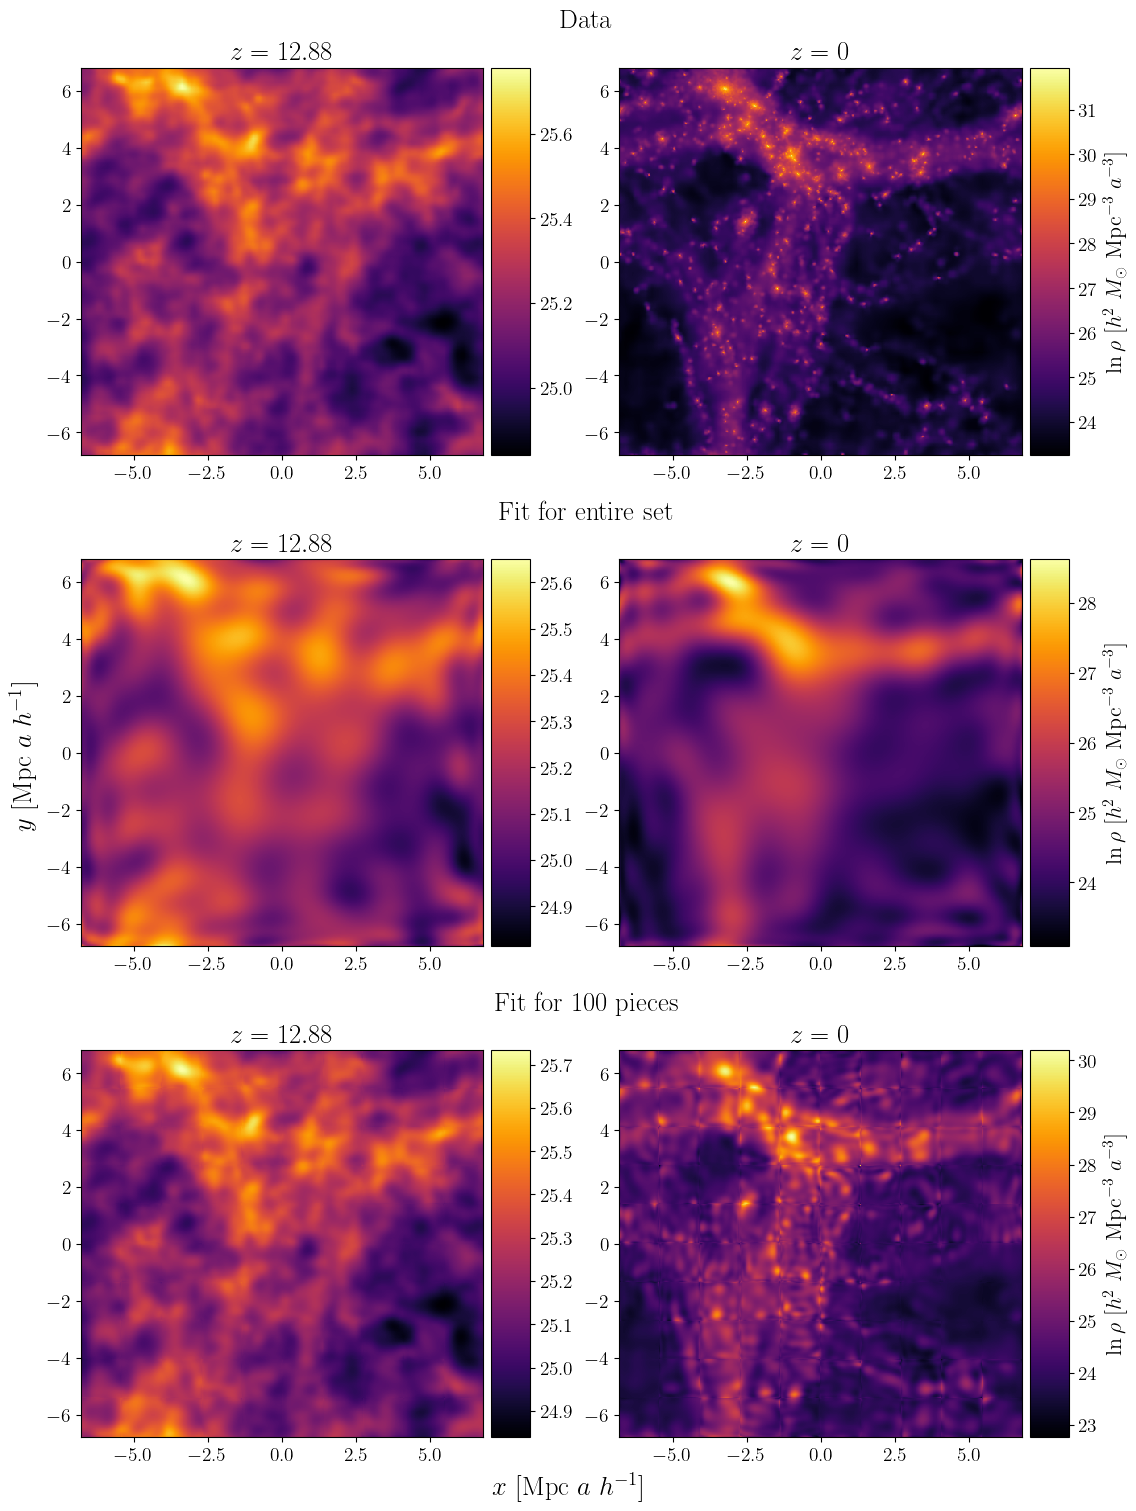

In [116]:
suptitles = ["Data", "Fit for entire set", "Fit for 100 pieces"]
titles = [r"$z=12.88$", r"$z=0$"]

fig = plt.figure(figsize = (11.25, 15), constrained_layout = True)
subfigs = fig.subfigures(3, 1)
im = []
for i in range(3):
    axs = subfigs[i].subplots(1, 2)
    subfigs[i].suptitle(suptitles[i])
    for j in range(2):
        im.append(axs[j].imshow(z_plots[j][i][::-1], cmap = "inferno", interpolation = "nearest", aspect = "auto", extent = [np.min(x), np.max(x), np.min(y), np.max(y)]))
        plt.colorbar(im[-1], ax = axs[j], label = r"$\ln\rho$ [" + rho_unit + "]" if j == 1 else None, pad = 0.02, aspect = 10)
        axs[j].set_title(titles[j])

fig.supxlabel(r"$x$ [" + box_unit + "]")
fig.supylabel(r"$y$ [" + box_unit + "]")
plt.savefig("../figs/density_pieces.pdf")
plt.show()

#### Comment for the report:

1. CONFIRM?

### Ridge: MSE and $R^2$ as function of hyperparameter $\lambda$ and polynomial degree

In [127]:
lambdas = np.logspace(-7, 0, 11)
degrees = range(1, 32, 3)

MSE_Ridge_list = []
R2_Ridge_list = []
for z in z_list:
    MSE_Ridge_list.append(np.zeros((len(degrees), len(lambdas))))
    R2_Ridge_list.append(np.zeros((len(degrees), len(lambdas))))
    for i in range(len(degrees)):
        for j in range(len(lambdas)):
            MSE_Ridge, R2_Ridge = Ridge(x, y, z, degrees[i], lambdas[j], seed = seed)
            MSE_Ridge_list[-1][i, j] = MSE_Ridge
            R2_Ridge_list[-1][i, j] = R2_Ridge

#### Plotting 

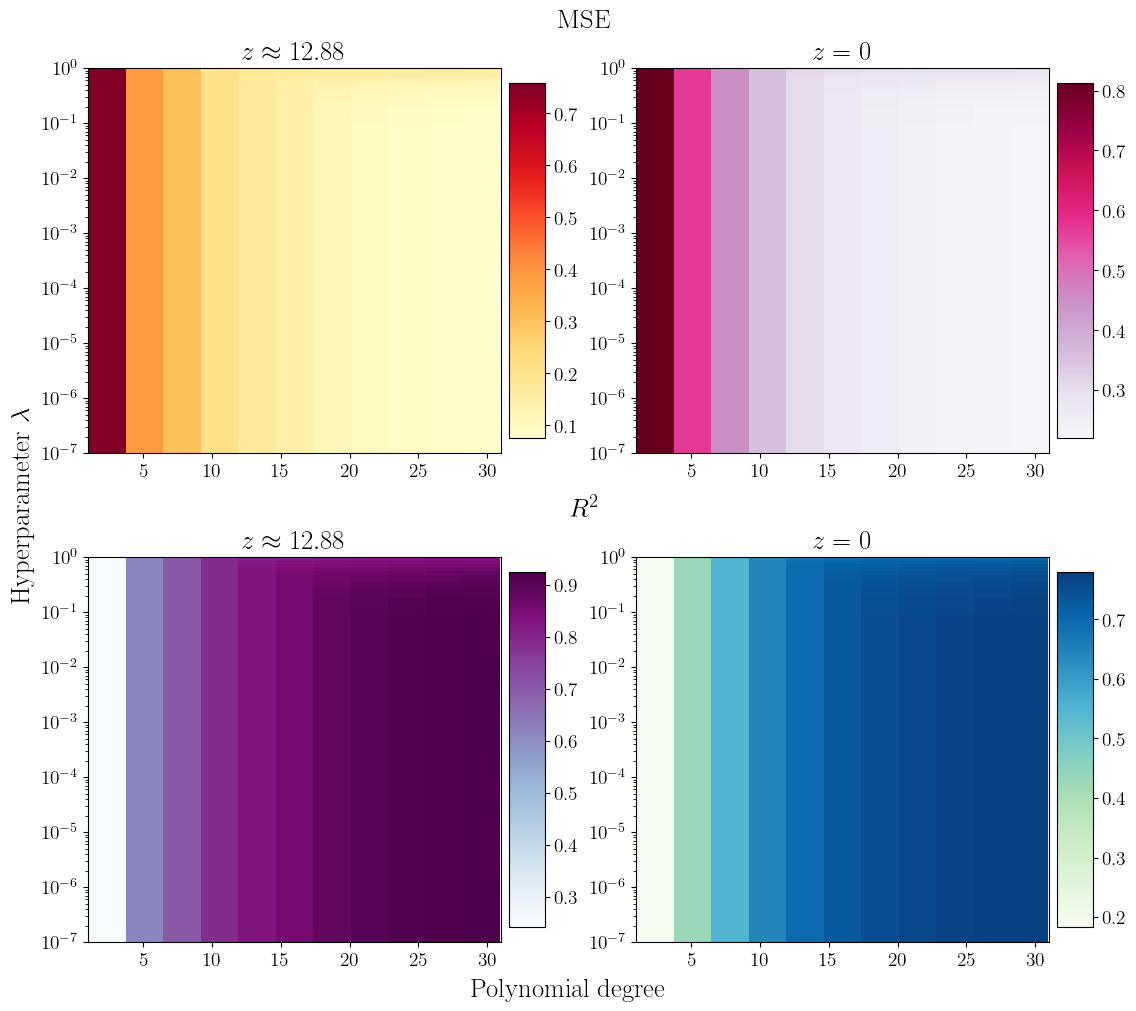

In [136]:
values = [MSE_Ridge_list, R2_Ridge_list]
suptitles = ["MSE", r"$R^2$"]
titles = [r"$z\approx12.88$", r"$z=0$"]
cmaps = [["YlOrRd", "PuRd"], ["BuPu", "GnBu"]]
extent = [np.min(degrees), np.max(degrees), np.min(lambdas), np.max(lambdas)]

fig = plt.figure(figsize = (11.25, 10), constrained_layout = True)
subfigs = fig.subfigures(2, 1)
im = []
for i in range(2):
    axs = subfigs[i].subplots(1, 2)
    subfigs[i].suptitle(suptitles[i])
    for j in range(2):
        im.append(axs[j].imshow(values[i][j].T[::-1], cmap = cmaps[i][j], aspect = "auto", extent = extent))
        plt.colorbar(im[-1], ax = axs[j], pad = 0.02, shrink = 0.92, aspect = 10)
        axs[j].set_yscale("log")
        axs[j].set_title(titles[j])

fig.supxlabel("Polynomial degree")
fig.supylabel(r"Hyperparameter $\lambda$")
plt.savefig("../figs/g_MSE_R2_Ridge.pdf")
plt.show()

#### Cropping to look at high complexity, large $\lambda$

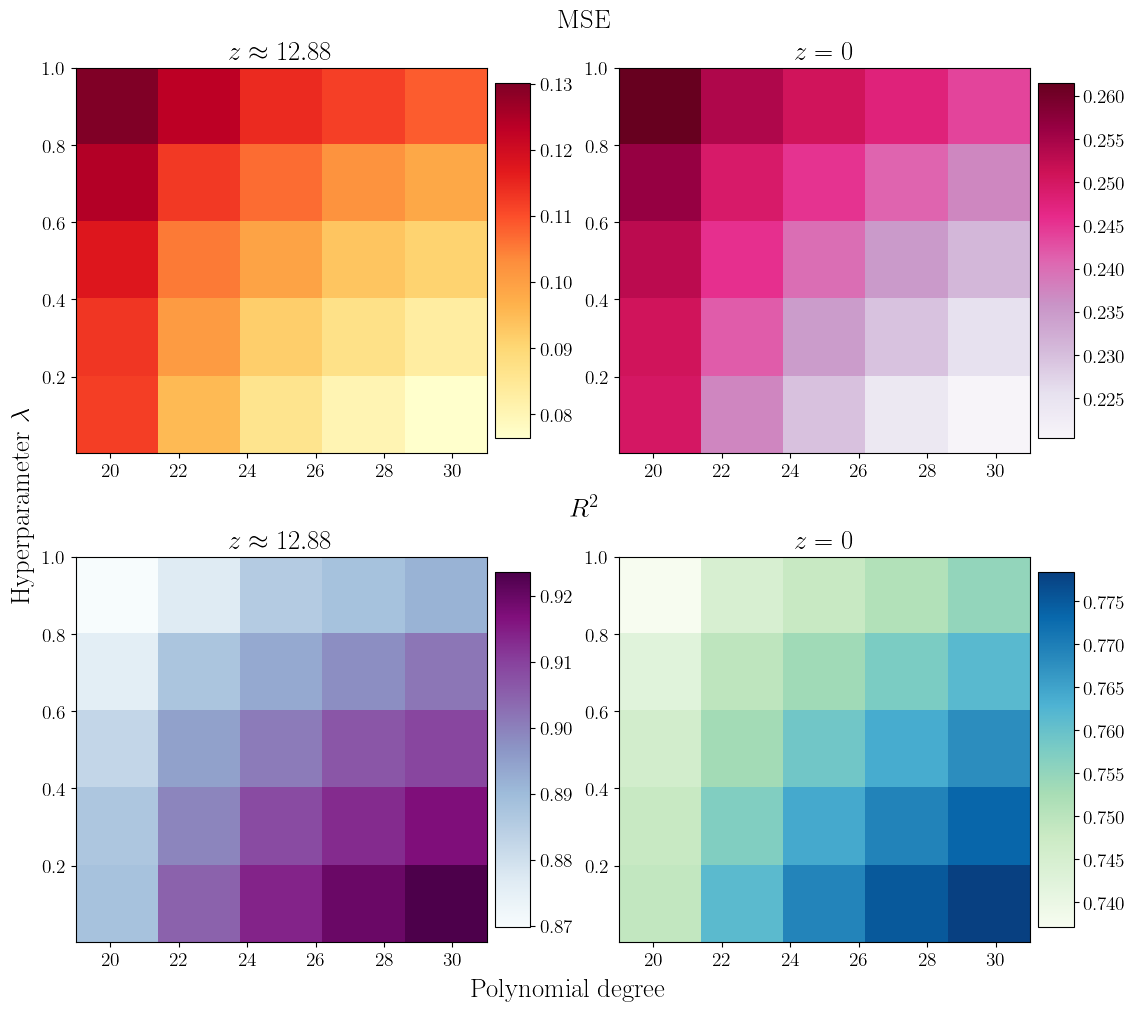

In [140]:
values = [MSE_Ridge_list, R2_Ridge_list]
suptitles = ["MSE", r"$R^2$"]
titles = [r"$z\approx12.88$", r"$z=0$"]
cmaps = [["YlOrRd", "PuRd"], ["BuPu", "GnBu"]]
extent = [np.min(degrees[6:]), np.max(degrees[6:]), np.min(lambdas[6:]), np.max(lambdas[6:])]

fig = plt.figure(figsize = (11.25, 10), constrained_layout = True)
subfigs = fig.subfigures(2, 1)
im = []
for i in range(2):
    axs = subfigs[i].subplots(1, 2)
    subfigs[i].suptitle(suptitles[i])
    for j in range(2):
        im.append(axs[j].imshow(values[i][j].T[::-1][6:, 6:], cmap = cmaps[i][j], aspect = "auto", extent = extent))
        plt.colorbar(im[-1], ax = axs[j], pad = 0.02, shrink = 0.92, aspect = 10)
        axs[j].set_title(titles[j])

fig.supxlabel("Polynomial degree")
fig.supylabel(r"Hyperparameter $\lambda$")
plt.savefig("../figs/g_MSE_R2_Ridge_zoomed.pdf")
plt.show()

In [ ]:
#TODO new comments

#### Comments for the report:

1. In the range of polynomial degrees we have chosen we have not yet reached the point where the error starts increasing due to overfitting (test this!!!), hence why the MSE/$R^2$ scores steadily decrease/increase for increasing complexity.
2. Minimal dependence on the regularization term, and we actually see that the MSE increases with $\lambda$ as we move to higher complexities, contrary to what one might expect. This is because of what is mentioned in point 1: We have not yet reached the complexities where the MSE increases again, hence penalizing the coefficients of the higher order term increases the error instead of decreasing it, since we need the higher order terms to properly fit the data. 
3. The small dips that are seen in the dual axis plot are most likely random (look at the axes, the changes are minimal), especially since we see the dip for degree $4$ but not $5$ or $6$. Additionally, it varies with the chosen seed :-)

### Lasso: MSE and $R^2$ as function of hyperparameter $\lambda$ and polynomial degree

In [11]:
#TODO something is wrong here, try to implement without sci-kit

In [129]:
lambdas = np.logspace(-7, 0, 11)
degrees = range(1, 32, 3)

MSE_Lasso_list = []
R2_Lasso_list = []
for z in z_list:
    MSE_Lasso_list.append(np.zeros((len(degrees), len(lambdas))))
    R2_Lasso_list.append(np.zeros((len(degrees), len(lambdas))))
    for i in range(len(degrees)):
        for j in range(len(lambdas)):
            MSE_Lasso, R2_Lasso = Lasso(x, y, z, degrees[i], lambdas[j], seed = seed)
            MSE_Lasso_list[-1][i, j] = MSE_Lasso
            R2_Lasso_list[-1][i, j] = R2_Lasso

KeyboardInterrupt: 

In [14]:
#TODO fix after rest of Lasso is fixed

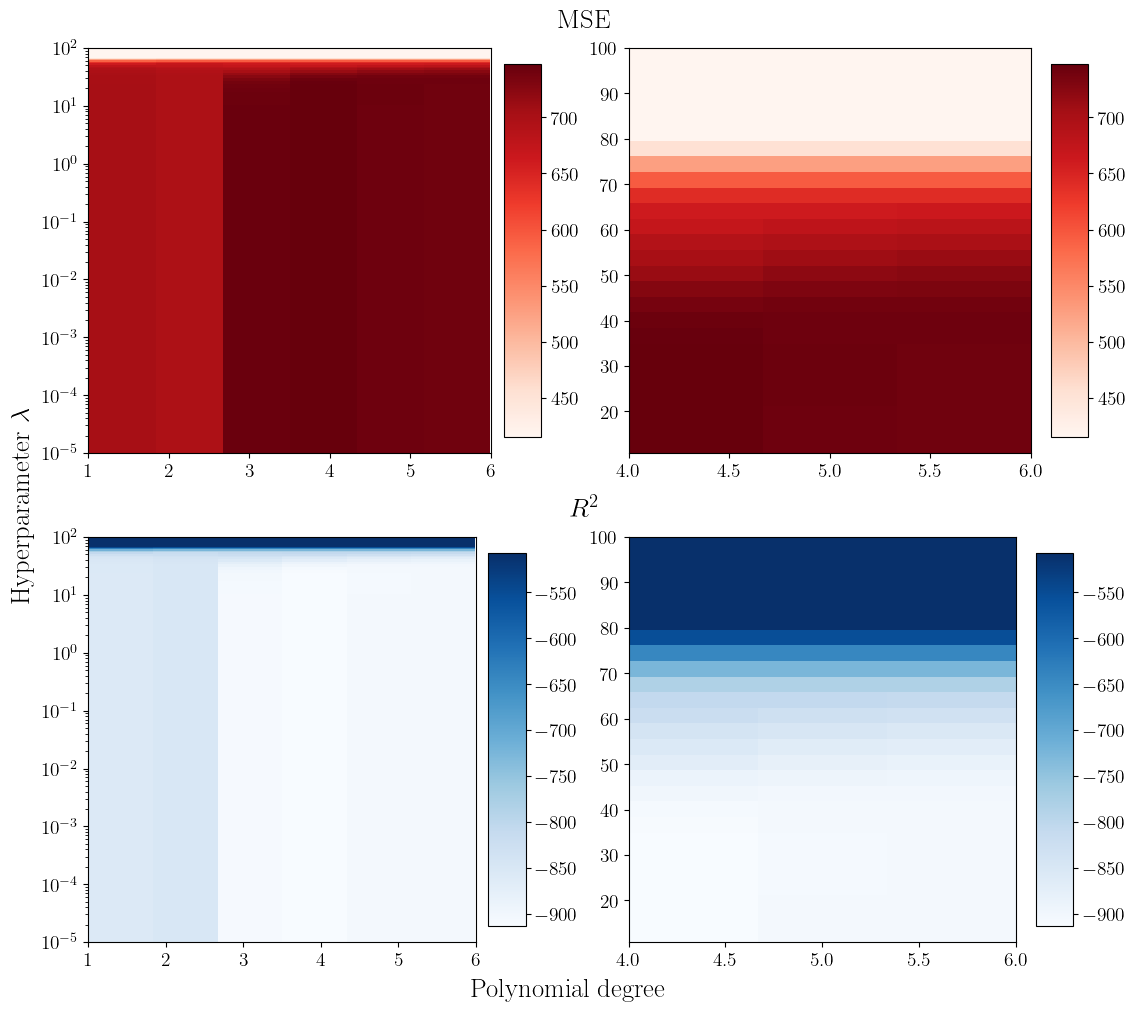

In [ ]:
fig = plt.figure(figsize = (11.25, 10), constrained_layout = True)
subfigs = fig.subfigures(2, 1)
im = []
for i in range(2):
    axs = subfigs[i].subplots(1, 2)
    subfigs[i].suptitle(suptitles[i])
    for j in range(2):
        im.append(axs[j].imshow(values[i][j].T[::-1], cmap = cmaps[i][j], aspect = "auto", extent = extent))
        plt.colorbar(im[-1], ax = axs[j], pad = 0.02, shrink = 0.92, aspect = 10)
        axs[j].set_yscale("log")
        axs[j].set_title(titles[j])

fig.supxlabel("Polynomial degree")
fig.supylabel(r"Hyperparameter $\lambda$")
plt.savefig("../figs/g_MSE_R2_Lasso.pdf")
plt.show()

In [ ]:
#TODO new comments

### OLS: Cross-validation performance as function of complexity and $k$, vs. bootstrap as function of complexity for $z=12.88$

In [141]:
n_bootstraps = 100
degrees = range(1, 32, 3)
k = range(5, 16)

OLS = LinearRegression(fit_intercept = False)

MSE_kfold = np.zeros((len(degrees), len(k)))
MSE_bootstrap = np.zeros(len(degrees))
for i in range(len(degrees)):
    MSE_bootstrap[i], bias, variance = Bootstrap(x, y, z_1288, degrees[i], n_bootstraps, seed = seed)
    for j in range(len(k)):
        MSE_kfold[i, j] = kfold_crossval(x, y, z_1288, k[j], OLS, degrees[i])

KeyboardInterrupt: 

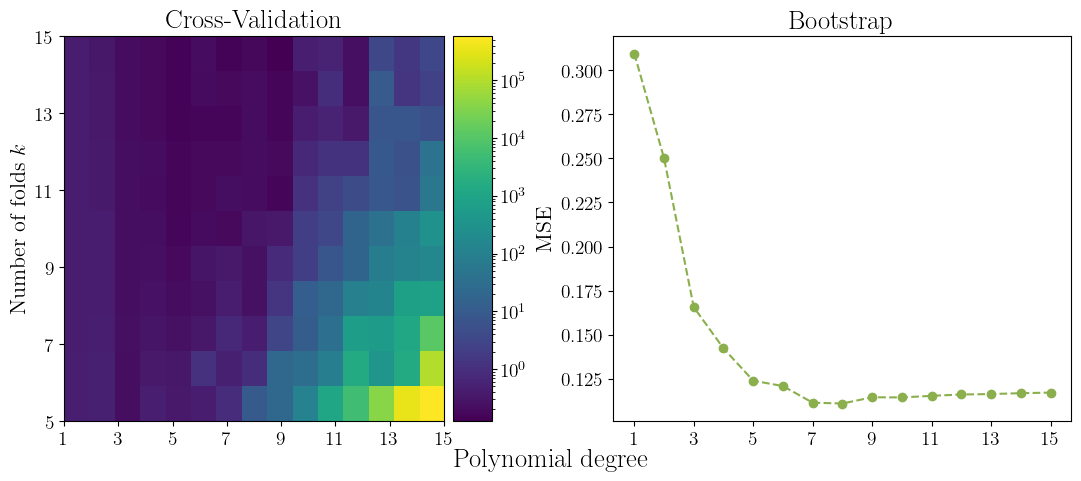

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (13, 5))
im = axs[0].imshow(MSE_kfold.T[::-1], aspect = "auto", norm = "log", extent = [np.min(degrees), np.max(degrees), np.min(k), np.max(k)])
plt.colorbar(im, ax = axs[0], pad = 0.02, aspect = 10)
axs[1].plot(degrees, MSE_bootstrap, "--o", color = "#8baf4d")
axs[0].set_xticks(degrees[::2])
axs[1].set_xticks(degrees[::2])
axs[0].set_yticks(k[::2])
axs[0].set_ylabel(r"Number of folds $k$")
axs[1].set_ylabel("MSE")
axs[0].set_title("Cross-Validation")
axs[1].set_title("Bootstrap")
fig.supxlabel("Polynomial degree")
plt.tight_layout
plt.savefig("../figs/g_kfold_vs_bootstrap.pdf")
plt.show()

In [ ]:
#TODO new comments

#### Comments for the report:

1. Very high MSE for large complexities if the number of $k$-folds is too low, while bootstrap stabilizes at a much lower MSE, even though it starts increasing again for polynomial degrees larger than $\sim7$.
2. We see from the intensity plot that a moderate to high $k$ and a polynomial degree around $4-8$ gives the lowest MSE, and that the number of $k$-folds is much more important for higher complexities. This makes sense, since cross-validation takes care of the rapid increase in variance that may arise from overfitting, but not the increase in bias due to underfitting (not at all? double check). We therefore see a slightly higher and seemingly constant MSE for the lowest complexities.
3. Bootstrap seems to be generally favorable for this synthetic dataset, which makes sense since it is relatively small ($50$ points in the $x$ and $y$ directions) (good reason?). This is most likely not the case as we move on to the simulation data, although bootstrap may perform better than cross-validation there as well for some other reason(s).

### OLS, Ridge and Lasso MSE as functions of complexity and number of folds $k$

In [66]:
N = 50
x = np.arange(0, 1, 1/N)
y = np.arange(0, 1, 1/N)
xx, yy = np.meshgrid(x, y)
x.reshape(-1, 1); y.reshape(-1, 1) 
z = (FrankeFunction(xx, yy) + np.random.normal(0, 0.1, (N, N))).reshape(-1, 1) 

lambdas = [0.001, 0.1]
degrees = range(1, 16)
k = range(5, 16)

OLS = LinearRegression(fit_intercept = False)

MSE_OLS, MSE_Ridge, MSE_Lasso = np.zeros((len(degrees), len(k))), np.zeros((len(degrees), len(k), len(lambdas))), np.zeros((len(degrees), len(k), len(lambdas)))
for i in range(len(degrees)):
    for j in range(len(k)):
        MSE_OLS[i, j] = kfold_crossval(x, y, z, k[j], OLS, degrees[i])
        for l in range(len(lambdas)):
            MSE_Ridge[i, j, l] = kfold_crossval(x, y, z, k[j], linear_model.Ridge(lambdas[l], fit_intercept = False), degrees[i])
            MSE_Lasso[i, j, l] = kfold_crossval(x, y, z, k[j], linear_model.Lasso(lambdas[l], fit_intercept = False), degrees[i])

#### Using colormaps instead

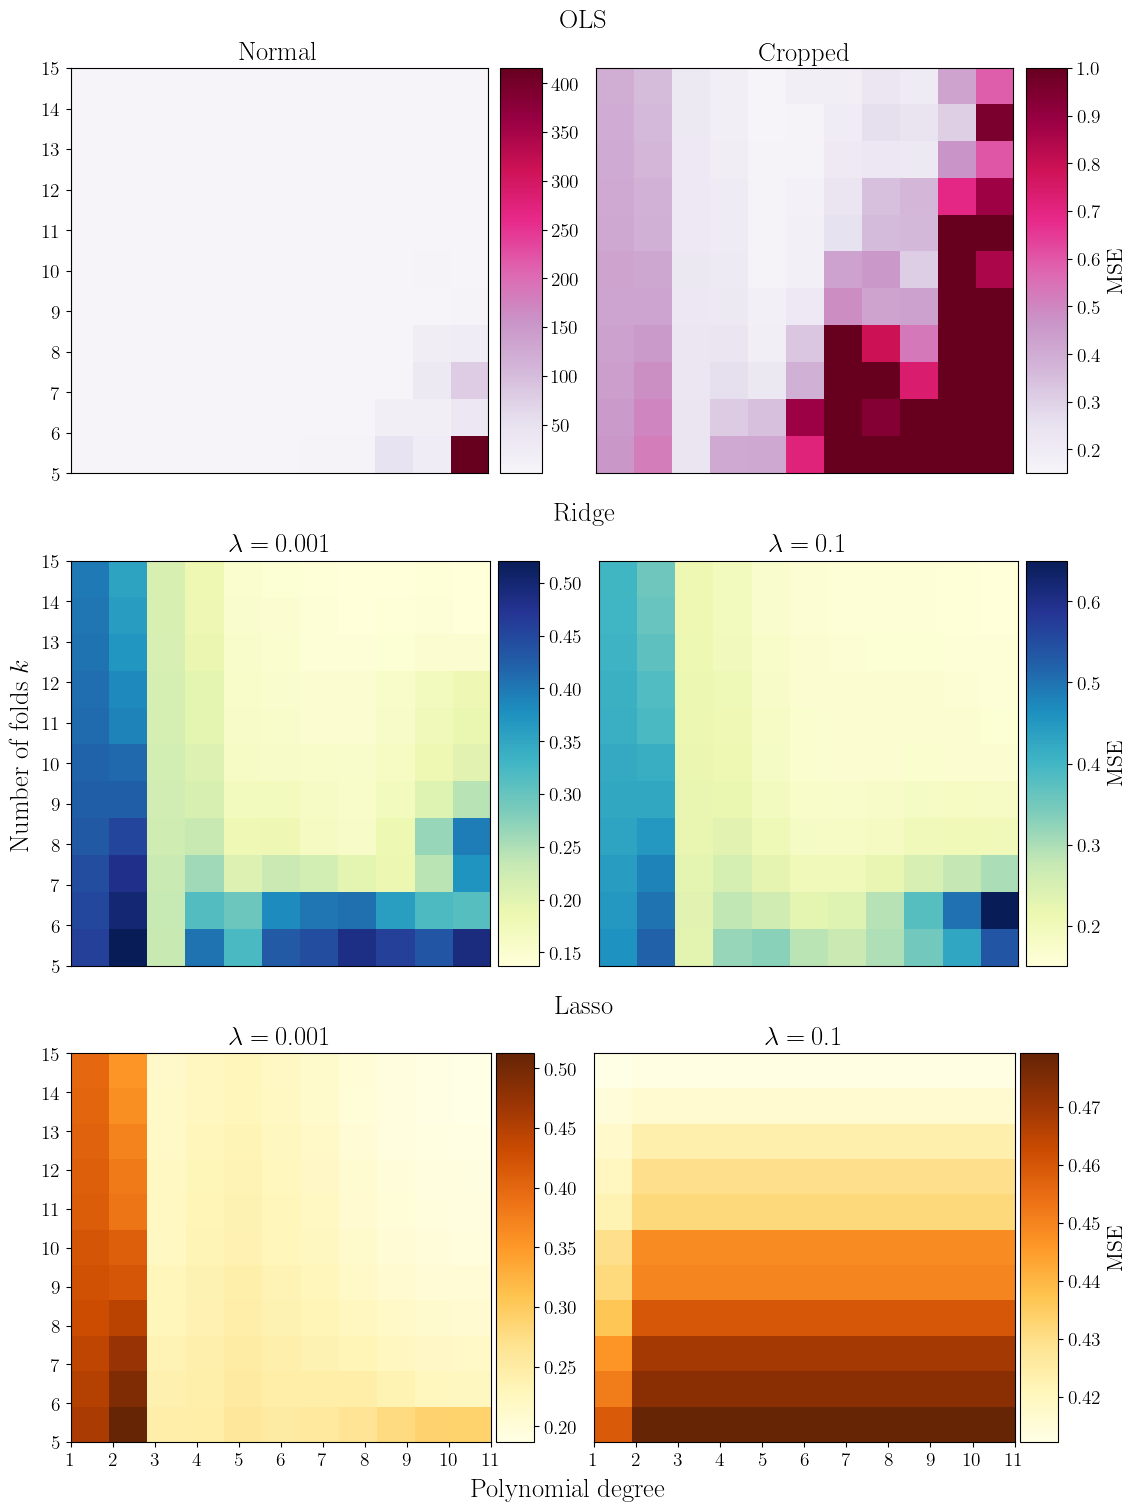

In [98]:
suptitles = ["OLS", "Ridge", "Lasso"]
titles = [["Normal", "Cropped"], [r"$\lambda=\:$" + f"{lambdas[0]}", r"$\lambda=\:$" + f"{lambdas[1]}"], [r"$\lambda=\:$" + f"{lambdas[0]}", r"$\lambda=\:$" + f"{lambdas[1]}"]]
cmaps = ["PuRd", "YlGnBu", "YlOrBr"]
pads = [0.03, 0.02, -0.01]
aspects = [9.8, 9.9, 10.2]
values = [MSE_OLS, MSE_Ridge, MSE_Lasso]

fig = plt.figure(figsize = (11.25, 15), constrained_layout = True)
subfigs = fig.subfigures(3, 1)
im = []
for i in range(3):
    axs = subfigs[i].subplots(1, 2)
    subfigs[i].suptitle(suptitles[i])
    # axs[0].set_yscale("log")
    for j in range(2):
        im.append(axs[j].imshow(values[i][:11].T[::-1] if i == 0 else values[i][:11, :, j].T[::-1], cmap = cmaps[i], aspect = "auto", vmax = 1 if (i == 0 and j == 1) else None, extent = [np.min(degrees[:11]), np.max(degrees[:11]), np.min(k), np.max(k)]))
        plt.colorbar(im[-1], ax = axs[j], pad = pads[i], aspect = aspects[i], label = "MSE" if j == 1 else None)
        axs[j].set_title(titles[i][j])
        axs[j].set_xticks(degrees[:11] if i == 2 else [])
        axs[j].set_yticks(k if j == 0 else [])

fig.supxlabel("Polynomial degree")
fig.supylabel(r"Number of folds $k$")
plt.savefig("../figs/f_OLS_Ridge_Lasso_imshow.pdf")
plt.show()

#### Comments for the report:

1. Higher complexity needs higher $k$ in all cases, as expected since otherwise the variance grows very large. This is especially visible for OLS, which becomes unstable for too large complexities (as expected since there is no regularization term?)
2. Too low complexity leads to larger MSE in all cases except for Lasso with $\lambda=0.1$ (why is that?), and increasing $k$ has minimal effect. This is not surprising, since the cross-validation mostly helps with decreasing the variance due to overfitting, not bias due to underfitting(?)
3. For Ridge and Lasso we have a sweet spot at intermediate to high complexity with $k\to10-15$, while for OLS we have a very bad fit if the polynomial degree exceeds $\sim5$, which is most likely because there's no regularization term. Thus, it may be best to stick with this complexity and $k$ between $5$ and $10$ somewhere, since this leads to MSE $\sim0.2-0.6$, which is around the same as we get for Ridge and Lasso. This is also the least computationally expensive option. This easy way out is not surprising since the Franke function is relatively smooth and simple. As we move on to the simulation data we will probably see that we need to opt for more complex alternatives with Ridge or Lasso and higher $k$.
4. For Lasso with $\lambda=0.1$, which is the main outlier here except for OLS at high complexity, we see that the MSE depends minimally on both $k$ and polynomial degree, contrary to the other cases. We may then assume that the ``pattern'' we see for the MSE is mostly random(?)